# Optuna: A hyperparameter optimization framework

* *In This Kernel I will use the amazing **Optuna** to find the best hyparameters of LGBM*

**So, Optuna is an automatic hyperparameter optimization software framework, particularly designed for machine learning. It features an imperative, define-by-run style user API. The code written with Optuna enjoys high modularity, and the user of Optuna can dynamically construct the search spaces for the hyperparameters.** 
* To learn more about Optuna check this [link](https://optuna.org/)

# Basic Concepts
So, We use the terms study and trial as follows:
* Study: optimization based on an objective function
* Trial: a single execution of the objective function

In [1]:
#!pip install optuna 
import optuna

In [7]:
from lightgbm import LGBMRegressor
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
train = pd.read_csv('../input/tabular-playground-series-feb-2021/train.csv')
test  = pd.read_csv('../input/tabular-playground-series-feb-2021/test.csv')
sub = pd.read_csv('../input/tabular-playground-series-feb-2021/sample_submission.csv')

In [4]:
train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,A,B,A,A,B,D,A,E,C,...,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903,6.994023
1,2,B,A,A,A,B,B,A,E,A,...,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464,8.071256
2,3,A,A,A,C,B,D,A,B,C,...,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352,5.760456
3,4,A,A,A,C,B,D,A,E,G,...,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766,7.806457
4,6,A,B,A,A,B,B,A,E,C,...,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743,6.868974


In [5]:
categorical_cols=['cat'+str(i) for i in range(10)]
continous_cols=['cont'+str(i) for i in range(14)]

## Encode categorical features

In [11]:
for e in categorical_cols:
    le = LabelEncoder()
    train[e]=le.fit_transform(train[e])
    test[e]=le.transform(test[e])

In [12]:
data=train[categorical_cols+continous_cols]
target=train['target']

In [14]:
data.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,0,1,0,0,1,3,0,4,2,8,...,0.281421,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903
1,1,0,0,0,1,1,0,4,0,5,...,0.282354,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464
2,0,0,0,2,1,3,0,1,2,13,...,0.293756,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352
3,0,0,0,2,1,3,0,4,6,10,...,0.769785,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766
4,0,1,0,0,1,1,0,4,2,5,...,0.279105,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743


## Let's build our optimization function using optuna

### This function uses LGBMRegressor model, takes 
* the data
* the target
* trial(How many executions we will do)  
#### and returns
* RMSE(Root Mean Squared Rrror)

## Notes:
* Note that I used some LGBMRegressor hyperparameters from LGBM official site. 
* So if you like to add more parameters or change them, check this [link](https://lightgbm.readthedocs.io/en/latest/Parameters.html) 
* Also I used early_stopping_rounds to avoid overfiting

In [19]:
def objective(trial,data=data,target=target):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)
    param = {
        'metric': 'rmse', 
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

## All thing is ready So let's start 🏄‍
* Note that the objective of our fuction is to minimize the RMSE that's why I set direction='minimize'
* you can vary n_trials(number of executions) 

In [20]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-02-04 13:48:01,587] A new study created in memory with name: no-name-900040c1-fe9b-4a95-8e00-bb57df00e6b1
[I 2021-02-04 13:49:11,592] Trial 0 finished with value: 0.8426000693073501 and parameters: {'reg_alpha': 5.8584324267071235, 'reg_lambda': 4.533540617965413, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 789, 'min_child_samples': 260, 'min_data_per_groups': 77}. Best is trial 0 with value: 0.8426000693073501.
[I 2021-02-04 13:49:52,534] Trial 1 finished with value: 0.843073554800439 and parameters: {'reg_alpha': 0.00274228231268007, 'reg_lambda': 4.406271684675252, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 9, 'min_child_samples': 215, 'min_data_per_groups': 30}. Best is trial 0 with value: 0.8426000693073501.
[I 2021-02-04 13:50:40,370] Trial 2 finished with value: 0.8442185103864116 and parameters: {'reg_alpha': 0.7908445310685409, 'reg_lambda': 0.013316031057346118

[I 2021-02-04 14:10:17,719] Trial 22 finished with value: 0.8425298983782161 and parameters: {'reg_alpha': 0.01810452202076926, 'reg_lambda': 0.002301750459569976, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 159, 'min_child_samples': 298, 'min_data_per_groups': 15}. Best is trial 10 with value: 0.8424445761667749.
[I 2021-02-04 14:11:15,951] Trial 23 finished with value: 0.8424820562339183 and parameters: {'reg_alpha': 0.013348449074954607, 'reg_lambda': 0.0017421208701366864, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 145, 'min_child_samples': 271, 'min_data_per_groups': 47}. Best is trial 10 with value: 0.8424445761667749.
[I 2021-02-04 14:12:11,710] Trial 24 finished with value: 0.8425760130822344 and parameters: {'reg_alpha': 0.006177696286746485, 'reg_lambda': 0.007939112374524607, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 10, 'num_leav

[I 2021-02-04 14:30:17,432] Trial 44 finished with value: 0.8433882568371416 and parameters: {'reg_alpha': 6.057561702178017, 'reg_lambda': 0.002261038946857698, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 220, 'min_child_samples': 266, 'min_data_per_groups': 20}. Best is trial 42 with value: 0.8423859659530323.
[I 2021-02-04 14:31:31,145] Trial 45 finished with value: 0.8424822456806085 and parameters: {'reg_alpha': 1.409993665324953, 'reg_lambda': 0.003810932532483848, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 105, 'min_child_samples': 300, 'min_data_per_groups': 8}. Best is trial 42 with value: 0.8423859659530323.
[I 2021-02-04 14:32:50,881] Trial 46 finished with value: 0.8443946986073995 and parameters: {'reg_alpha': 3.752531494364217, 'reg_lambda': 0.21161250927174843, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 104, '

Number of finished trials: 50
Best trial: {'reg_alpha': 6.147694913504962, 'reg_lambda': 0.002457826062076097, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 111, 'min_child_samples': 285, 'min_data_per_groups': 39}


In [21]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_samples,params_min_data_per_groups,params_num_leaves,params_reg_alpha,params_reg_lambda,params_subsample,state
0,0,0.842600,2021-02-04 13:48:01.590435,2021-02-04 13:49:11.591786,0 days 00:01:10.001351,0.3,0.008,10,260,77,789,5.858432,4.533541,0.6,COMPLETE
1,1,0.843074,2021-02-04 13:49:11.593611,2021-02-04 13:49:52.534127,0 days 00:00:40.940516,0.3,0.017,20,215,30,9,0.002742,4.406272,1.0,COMPLETE
2,2,0.844219,2021-02-04 13:49:52.536320,2021-02-04 13:50:40.370175,0 days 00:00:47.833855,0.7,0.010,10,202,85,830,0.790845,0.013316,1.0,COMPLETE
3,3,0.844563,2021-02-04 13:50:40.372803,2021-02-04 13:51:41.258567,0 days 00:01:00.885764,0.8,0.008,100,70,52,253,0.002923,0.034455,0.6,COMPLETE
4,4,0.844663,2021-02-04 13:51:41.261245,2021-02-04 13:52:09.017338,0 days 00:00:27.756093,1.0,0.017,10,101,57,66,0.030099,0.060261,0.5,COMPLETE
5,5,0.843458,2021-02-04 13:52:09.019432,2021-02-04 13:52:44.818050,0 days 00:00:35.798618,0.8,0.020,100,172,1,13,0.006976,6.923024,0.6,COMPLETE
6,6,0.845335,2021-02-04 13:52:44.819853,2021-02-04 13:53:15.262129,0 days 00:00:30.442276,0.9,0.017,10,178,5,704,0.068518,0.253338,0.7,COMPLETE
7,7,0.847161,2021-02-04 13:53:15.265626,2021-02-04 13:55:13.005385,0 days 00:01:57.739759,0.9,0.006,20,144,85,987,1.059651,0.116394,0.6,COMPLETE
8,8,0.844311,2021-02-04 13:55:13.007876,2021-02-04 13:57:05.516696,0 days 00:01:52.508820,0.4,0.006,100,4,16,823,0.001795,0.426474,0.4,COMPLETE
9,9,0.845647,2021-02-04 13:57:05.518663,2021-02-04 13:57:44.993260,0 days 00:00:39.474597,0.7,0.020,20,33,74,661,6.479361,0.065476,0.5,COMPLETE


# Let's do some Quick Visualization for Hyperparameter Optimization Analysis
### Optuna provides various visualization features in optuna.visualization to analyze optimization results visually

In [22]:
#plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
optuna.visualization.plot_optimization_history(study)

In [23]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

In [24]:
'''plot_slice: shows the evolution of the search. You can see where in the hyperparameter space your search
went and which parts of the space were explored more.'''
optuna.visualization.plot_slice(study)

In [28]:
#plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
optuna.visualization.plot_contour(study, params=['num_leaves',
                            'max_depth',
                            'subsample',
                            'learning_rate',
                            'subsample'])

In [29]:
#Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

In [30]:
#Visualize empirical distribution function
optuna.visualization.plot_edf(study)

# Let's create an LGBMRegressor model with the best hyperparameters

In [43]:
params=study.best_params   
params['random_state'] = 48
params['n_estimators'] = 20000 
params['metric'] = 'rmse'

In [47]:
# I changed min_data_per_groups to cat_smooth beacuse when I used LGBM params in optuna I named cat_smooth
# as min_data_per_groups (there is no parameter named min_data_per_groups in LGBM !!!)
params['cat_smooth'] = params.pop('min_data_per_groups')

In [49]:
params

{'reg_alpha': 6.147694913504962,
 'reg_lambda': 0.002457826062076097,
 'colsample_bytree': 0.3,
 'subsample': 0.8,
 'learning_rate': 0.008,
 'max_depth': 20,
 'num_leaves': 111,
 'min_child_samples': 285,
 'random_state': 48,
 'n_estimators': 20000,
 'metric': 'rmse',
 'cat_smooth': 39}

In [50]:
columns = categorical_cols+continous_cols
preds = np.zeros(test.shape[0])
kf = KFold(n_splits=5,random_state=48,shuffle=True)
rmse=[]  # list contains rmse for each fold
n=0
for trn_idx, test_idx in kf.split(train[columns],train['target']):
    X_tr,X_val=train[columns].iloc[trn_idx],train[columns].iloc[test_idx]
    y_tr,y_val=train['target'].iloc[trn_idx],train['target'].iloc[test_idx]
    model = LGBMRegressor(**params)
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)
    preds+=model.predict(test[columns])/kf.n_splits
    rmse.append(mean_squared_error(y_val, model.predict(X_val), squared=False))
    print(n+1,rmse[n])
    n+=1

1 0.8422516588731099
2 0.8454641176530182
3 0.8435247420802582
4 0.8396584022816828
5 0.8409088145101996


In [51]:
np.mean(rmse)

0.8423615470796537

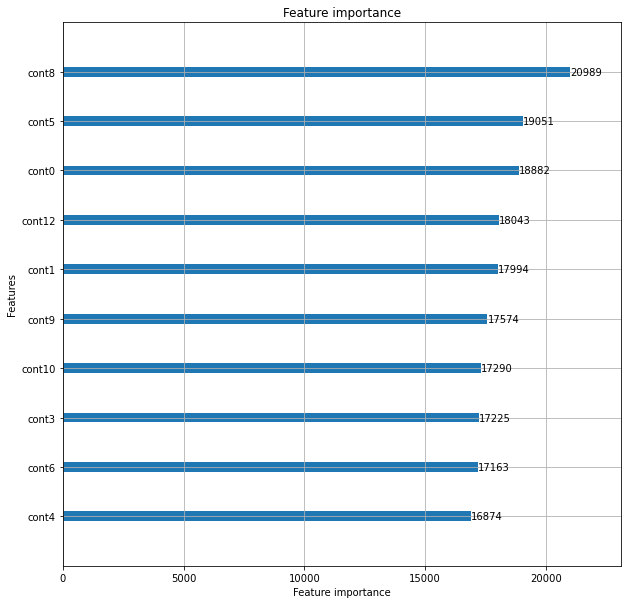

In [59]:
from optuna.integration import lightgbm as lgb
lgb.plot_importance(model, max_num_features=10, figsize=(10,10))
plt.show()


# Submission

In [60]:
sub['target']=preds
sub.to_csv('submission.csv', index=False)

# # Please If you find this kernel helpful, upvote it to help others see it 😊 😋